# Watersheed
Segmentación basada en el algoritmo de watersheed o "cuenca hidrográfica"

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
# %matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

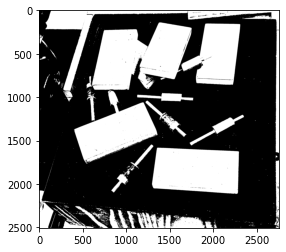

In [2]:
# Cargamos la imagen y la binarizamos por el método de Otzu
img = cv.imread('Piezas2.png')

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Binarizamos...
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.figure()
plt.imshow(thresh,cmap='gray')

### Marcadores

El método de watersheed por OpenCV precisa que se le indiquen los marcadores (semillas) de manera que no se genere sobremarcación.

Esto se logra a través de operaciones morfológicas

#### Operaciones morfológicas

Se busca intentar separar fondo de objetos lo mejor posible. Quedará:

- Una zona de fondo seguro
- Una zona de objetos seguro
- Una zona de incertezas (la resta de las dos anteriores)

243.1969


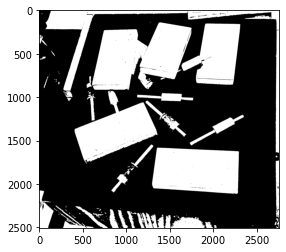

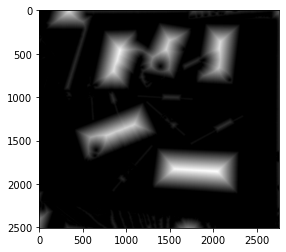

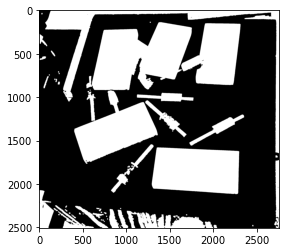

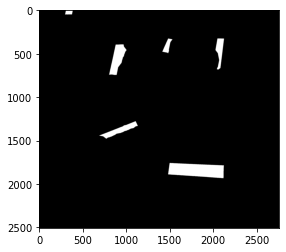

In [3]:
# Reducción de ruido
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

plt.figure()
plt.imshow(opening,cmap='gray')

# Área de fondo (background) segura
sure_bg = cv.dilate(opening,kernel,iterations=3)

# Búsqueda del área de objeto (foreground) segura --> Podría usar solo unaa erosion o la función distancia (para figuras que se tocan)

# MÉTODO 1: Solo erosión
#-----------------------
# sure_fg = cv.erode (opening, kernel, iterations = 3)

# MÉTODO 2: Transformación de distancia (distancia de cada píxel al cero más cercano)
#------------------------------------------------------------------------------------
# Conviene cerrar primero la figura para que no haya agujeros (ceros) dentro de los objetos que afecten la transformada
closing = cv.morphologyEx(opening,cv.MORPH_CLOSE,kernel, iterations = 2)
# Ahora sí aplicamos la transformación de distancia
dist_transform = cv.distanceTransform(closing,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
print(dist_transform.max())

# Búsqueda de la región no definida
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

#Graficamos...
#=============
fig=plt.figure('Transformación de distancia')
plt.imshow(dist_transform,cmap='gray')

fig=plt.figure('Objetos seguros')
plt.imshow(sure_bg,cmap='gray')

fig=plt.figure('Fondo seguro')
plt.imshow(sure_fg,cmap='gray')
plt.show()

#### Etiquetado

En función del análisis morfológico anterior es que se realiza el etiquetado (utilizando componentes conexos)

- Cada supuesto objeto con una etiqueta diferente
- Los pixeles con incertidumbre con etiqueta 0

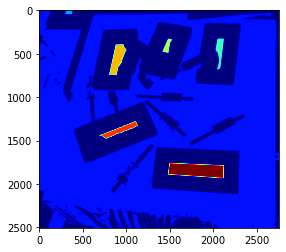

In [4]:
# Etiquetado de marcadores
ret, markers = cv.connectedComponents(sure_fg)
# Agregar un uno ('1') a todas las etiquetas (para evitar la etiqueta '0')
markers = markers+1
# Ahora, marcamos la región de incertezas con cero
markers[unknown==255] = 0

plt.figure()
plt.imshow(markers,cmap='jet')

### Watersheed

Una vez definidos los marcadores se corre el algoritmo de watersheed.

Los bordes (devueltos por el algoritmo con valor -1) los "pintamos" de color rojo

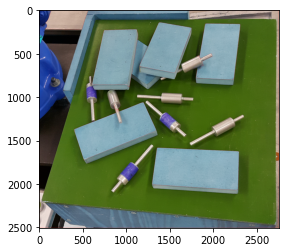

In [5]:
img_out = img.copy()
markers = cv.watershed(img_out,markers)
img_out[markers == -1] = [255,0,0]

plt.figure()
plt.imshow(img_out,cmap='jet')